## Przygotowanie

Przed rozpoczęciem pracy z notatnikiem proszę zmienić jego nazwę dodając na początku numer albumu, imię i nazwisko.
{nr_albumu}\_{imię}\_{nazwisko}\_{nazwa}

Po wykonaniu wszystkich zadań proszę przesłać wypełniony notatnik przez TEAMS w wiadomości prywatnej.

## Regresja liniowa wieloraka

Rzadko kiedy zdarza się taka sytuacja, że zależność opisuje się na podstawie tylko jednej zmiennej. Z reguły na wynik zmiennej objaśnianej ($y$) ma wpły więcej różnych cech. Przykładowo, na cenę samochodu ma wpływ rok produkcji, przebieg, ilość koni mechanicznych itp. Dlatego właśnie jest naturalna potrzeba rozwinięcia algorytmu regresji liniowej z jedną cechą na większą ilość cech.

Algorytm, który implementowaliśmy w poprzednim zadaniu jest szczególnym przypadkiem regresji liniowej, ale może zostać on w łatwy sposób uogólniony. Mechanizmy, które poznaliśmy wcześniej takie jak obliczanie funkcji błędu, pochodnych cząstkowych, w dalszym ciągu są aktualne. Trzeba jedynie uwzględnić dodatkowe cechy.

### Zadanie 1

W zbiorze danych z zarobkami, który wykorzystywany był w poprzednim zadaniu, znajduje się pominięta wcześniej cecha. Wczytaj dane z pliku Salary.csv, tym razem z dwiema zmiennymi objaśniającymi: YearsExperience i Age oraz zmienną objaśnianą Salary. Stwórz wykres 3D przedstawiający dane.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('datasets/Salary.csv', sep=',')

df.head()

,YearsExperience,Age,Salary
0,1.1,20,39343
1,1.3,21,46205
2,1.5,21,37731
3,2.0,22,43525
4,2.2,22,39891


In [2]:
df.describe()

,YearsExperience,Age,Salary
count,35.000000,35.000000,35.000000
mean,6.308571,28.371429,83888.428571
std,3.618610,5.568217,32200.112889
min,1.100000,20.000000,37731.000000
25%,3.450000,24.000000,57019.000000
50%,5.300000,27.000000,81363.000000
75%,9.250000,32.500000,113223.500000
max,13.500000,40.000000,139465.000000


Text(0.5, 0, 'Salary')

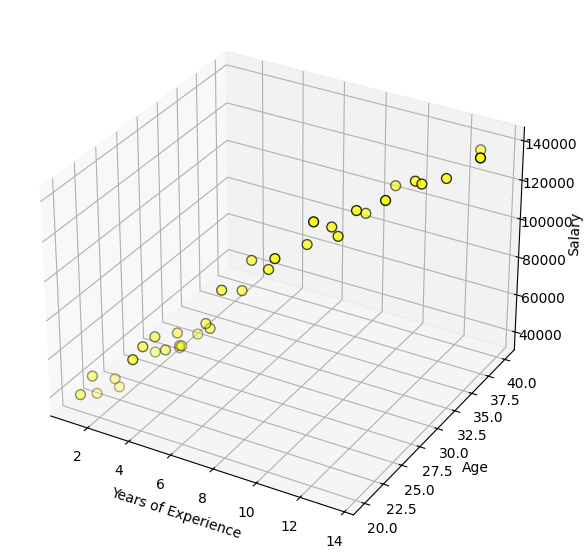

In [3]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['YearsExperience'], df['Age'], df['Salary'], c='yellow', s=50, edgecolors='k')

ax.set_xlabel('Years of Experience')
ax.set_ylabel('Age')
ax.set_zlabel('Salary')

## Zadanie 2

Przerób algorytm znajdujący się w funkcji _learn_and_fit(x,y)_ w taki sposób, aby uwzględniał dodatkową cechę.
Funkcja regresji liniowej przybierze w tym momencie postać:

\begin{equation}
f(x^{(i)}) = \beta_{0} + \beta_{1}x_1 + \beta_{2}x_2 = \beta_{0} + \beta_{1} YearsExperience + \beta_{2} Age
\end{equation}

Pojawienie się kolejnej cechy wymaga akutalizacji obliczania gradientu. Należy dodatkowo obliczyć pochodną cząstkową względem parametru $\beta_{2}$, a następnie zaktualizować wartość tego parametru. 

Obliczenie pochodnej cząstkowej wygląda analogicznie jak w przypadku parametru $\beta_{1}$.

\begin{equation}
    \frac{\partial SSR}{\partial \beta_{2}} = \frac{1}{n} \sum^{n}_{i=1} (f(x^{(i)}) - y^{(i)})x_{1}^{(i)}
\end{equation}

Aktualizacja wartości współczynnika również jest analogiczna.

\begin{equation}
    \beta_{2} = \beta_{2} - \alpha \frac{\partial SSR}{\partial \beta_{2}} 
\end{equation}

_Uwaga: Zastanów się, w jaki sposób zaimplementować obługę kolejnych cech, tak aby po pojawieniu się 3 cechy nie trzeba było modyfikować algorytmu._

In [4]:
import random
from typing import Tuple, List


def initialize_coefficients(n: int = 2, alpha = None) -> Tuple[float, np.ndarray]:
    epsilon = 1e-8

    betas = []
    for i in range(n+1):
        beta = np.random.rand() + epsilon
        betas.append(beta)

    if alpha is None:
        alpha = random.random() * 0.01 + epsilon

    return alpha, betas


def calculate_regression_function(X: np.ndarray, betas: np.ndarray) -> np.ndarray:
    beta0 = betas[0]
    weights = betas[1:]
    y_pred = beta0 + np.dot(X, weights)
    return y_pred


def calculate_error(predictions: np.ndarray, y: np.ndarray) -> float:
    ssr = 1/( 2*len(y) )*np.sum((predictions-y)**2)
    return ssr


def calculate_gradient(predictions: np.ndarray, y: np.ndarray, X: np.ndarray) -> np.ndarray:
    m = len(y)
    error = predictions - y
    X_bias = np.c_[np.ones(m), X]
    gradient = np.dot(X_bias.T, error) # X [2x35] error [1x35] X_bias [3x35]

    return gradient


def update_regression_coefficients(gradients: np.ndarray, betas: np.ndarray, alpha: float) -> np.ndarray:
    betas_new = betas - alpha*gradients
    return betas_new

In [5]:
X = df[["YearsExperience", "Age"]].values
y = df["Salary"].values

In [6]:
X.shape[1]

2

In [7]:
'''
input:
X - wartości zmiennych objaśniających YearsExperience oraz Age dla wszystkich obserwacji
y - wartości zmiennej objaśnianej Salary dla wszystkich obserwacji

output:
b0: [] - lista z współczynnikami beta_0 w każdej z epok
betas: [] - lista z współczynnikami beta_1, beta_2 w każdej z epok
error: [] - lista z błędem w każdej epoce
'''
def learn_and_fit(X: np.ndarray, y: np.ndarray, epoch: float = 100, stop_value: float = 0.01, alpha: float = None) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    alpha, betas = initialize_coefficients(X.shape[1], alpha)

    b0_history = []
    betas_history = []
    error_history = []
    
    for i in range(epoch):
        predictions = calculate_regression_function(X, betas)
        err = calculate_error(predictions, y)

        error_history.append(err)
        b0_history.append(betas[0])
        betas_history.append(betas[1:].copy())
        

        if err < stop_value:
            print(f" Warunek spełniony: err < 0.01, osiągnięto w {i+1} epoce")
            break
        gradients = calculate_gradient(predictions, y, X)
        betas = update_regression_coefficients(gradients, betas, alpha)

    return b0_history, betas_history, error_history

In [8]:
b0_hist, betas_hist, err_hist = learn_and_fit(X, y, epoch=500, stop_value=0.001, alpha=0.000001)

### Zadanie 3

Do stworzonego z zadaniu 1 wykresu dodaj płaszczyznę regresji. Stwórz 3 wykresy przedstawiające jak zmieniała się funkcja regresji na przestrzeni epok (pierwsza, środkowa, ostatnia epoka).

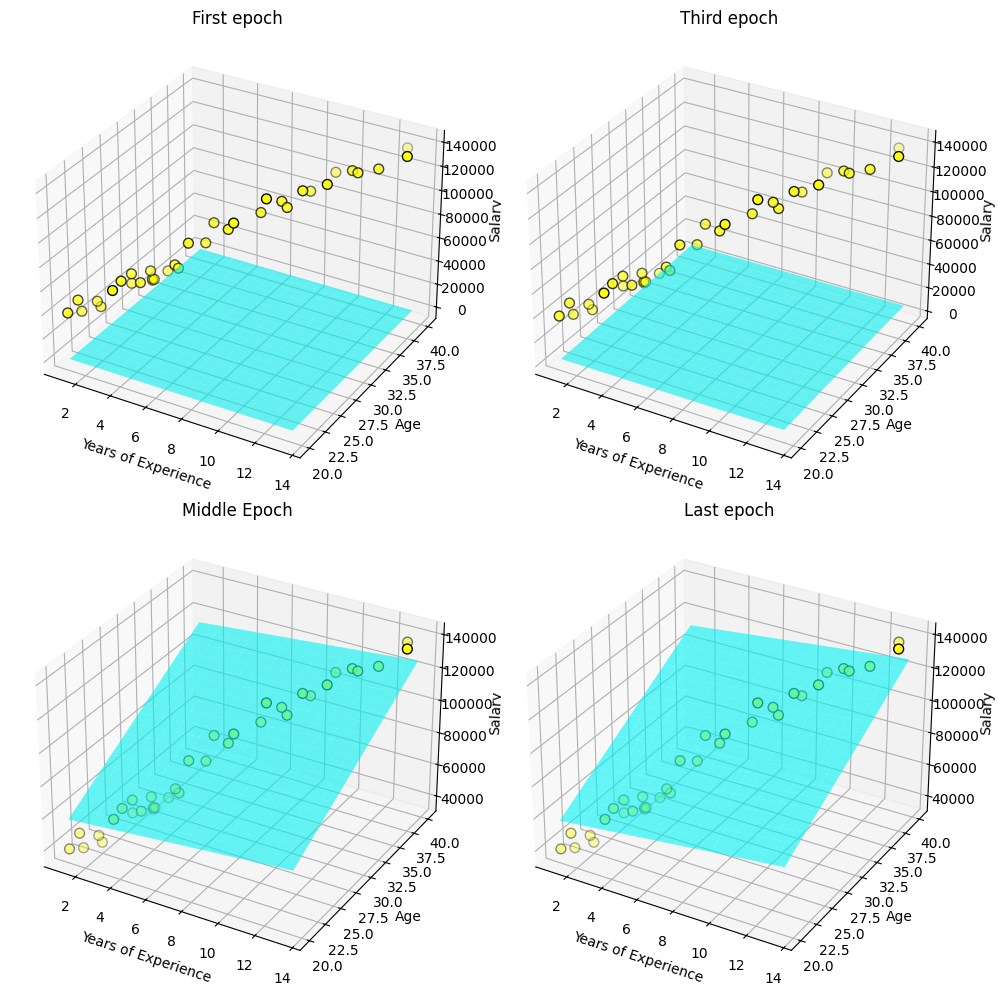

In [9]:
fig = plt.figure(figsize=(10, 10))

epochs = [0, 2, len(b0_hist)//2, len(b0_hist)-1]
titles = ["First epoch", "Third epoch", "Middle Epoch", "Last epoch"]

# siatka punktów do narysowania płaszczyzny
x = np.linspace(df["YearsExperience"].min(), df["YearsExperience"].max(), 20)
y = np.linspace(df["Age"].min(), df["Age"].max(), 20)
x_surf, y_surf = np.meshgrid(x, y)

for i, (ep, title) in enumerate(zip(epochs, titles), 1):
    ax = fig.add_subplot(2, 2, i, projection='3d')

    # współczynniki z danej epoki
    b0 = b0_hist[ep]
    b1, b2 = betas_hist[ep]

    # równanie płaszczyzny
    z_surf = b0 + b1 * x_surf + b2 * y_surf

    # dane rzeczywiste
    ax.scatter(df["YearsExperience"], df["Age"], df["Salary"], c="yellow", s=50, edgecolors="k")
    # płaszczyzna regresji
    ax.plot_surface(x_surf, y_surf, z_surf, color="cyan", alpha=0.6)

    ax.set_title(title)
    ax.set_xlabel("Years of Experience")
    ax.set_ylabel("Age")
    ax.set_zlabel("Salary")

plt.tight_layout()
plt.show()


### Zadanie 4

W sytuacji, w której zbiór danych zawiera więcej zmiennych objaśniających niż 2, niemożliwym staje się wizualizacja prostej regresji i ocena w taki sposób stworzonego modelu. Bardzo przydatnym rozwiązaniem jest wtedy stworzenie wykresu błędów regresji. Jeśli wartości błędu spadają wraz z kolejnymi epokami, oznacza to, że jesteśmy na dobrej drodze, a nasz algorytm działa poprawnie. Celem tego zadania będzie stworzenie finalnego modelu regresji liniowej, który będzie przyjmował dowolną liczbę zmiennych objaśniających.

Na podstawie wcześniejszych implementacji, stwórz implementację funkcji *learn_and_fit_multi(X, y)*, która będzie przyjmować zbiór wejściowy z dowolną ilością kolum (cech). Dla takiego zbioru zbioru danych ma zostać stworzony model regresji. Funkcja podobnie jak wcześniej, ma zwracać współczynniki oraz wartość błędu w każdej epoce. 

W notebooku z opisem regresji liniowej przedstawione zostały wzory na ogólą postać regresji. Przeanalizuj je jeszcze raz i postaraj się je zaimplementować.

Wczytaj zestaw danych *multi_variable_regression.csv* z katalogu datasets. Dane wygenerowane zostały w taki sposób, że są wysoce liniowo zależne. Wartość błędu dla nauczonego modelu powinna być w takim przypadku niewielka. Przetestuj na wczytanym zbiorze swój algorytm.

*Funckję learn_and_fit z góry przystosowałam pod większą liczbę zmiennych objaśniających*

In [10]:
df = pd.read_csv('multi_variable_regression.csv', sep=',')

df.head()

,x1,x2,x3,x4,x5,x6,y
0,-0.586479,0.457946,0.611877,1.234197,0.345695,0.574824,177.111999
1,-0.101979,-0.330872,0.391967,-0.238672,0.736806,-0.934582,-134.845687
2,-0.704671,-1.156918,0.510129,0.468877,0.402749,0.438787,-29.719439
3,-1.318963,1.030290,0.099815,0.395081,0.315859,-0.621132,-11.984118
4,-1.162739,-0.684766,-0.202388,0.726013,-0.093449,0.944595,47.913451


In [11]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

y

array([ 177.11199938, -134.84568705,  -29.71943895,  -11.98411828,
         47.91345148,  238.81682815, -149.6293249 ,  361.00279645,
         46.08668911,  323.60958201,  296.20068541,  344.78496084,
        -93.70071662,   -2.41890334,  148.19460865, -107.28445165,
        -78.10527268,  -58.37515593,  139.72048591,  140.91022474,
        128.34383711,  205.24287454,   64.54765987, -218.70771789,
        107.68885422,  -82.19148983,  117.3886929 , -134.31939533,
        -32.00027135,  213.78928589,  202.2453017 ,  -90.96657903,
       -163.31490976,  219.56479977,  -11.47068222,   11.82663528,
       -232.24426126,  346.30696923,  217.64957243,    2.85652518,
        262.19663688,   -6.30251447, -154.8722467 , -236.66333188,
        155.50407088,   38.62965067,  153.36279309,  -28.03608492,
        -36.02714045,   64.16046124, -111.8340345 ,  145.10701881,
       -174.29939601, -199.53911398,  -14.70696007,  114.71473219,
        296.54260169,  -70.28438896,    4.3941517 ,   70.37475

In [12]:
X

array([[-5.86479186e-01,  4.57945665e-01,  6.11877058e-01,
         1.23419705e+00,  3.45695320e-01,  5.74823738e-01],
       [-1.01978620e-01, -3.30872493e-01,  3.91966545e-01,
        -2.38672351e-01,  7.36806070e-01, -9.34581815e-01],
       [-7.04670976e-01, -1.15691812e+00,  5.10128698e-01,
         4.68877148e-01,  4.02748752e-01,  4.38787432e-01],
       [-1.31896251e+00,  1.03029037e+00,  9.98147918e-02,
         3.95080984e-01,  3.15859102e-01, -6.21132190e-01],
       [-1.16273858e+00, -6.84765705e-01, -2.02388229e-01,
         7.26012599e-01, -9.34494721e-02,  9.44594537e-01],
       [ 2.59307998e-01,  1.43996988e+00, -1.11315632e+00,
         1.49532947e+00,  1.70752594e+00, -2.42846734e-01],
       [-6.53699332e-01,  5.81377266e-01, -3.63679676e-01,
        -6.39519319e-01, -5.70463315e-01, -9.80033502e-01],
       [ 1.85204029e+00,  1.44318792e+00, -6.33245687e-01,
         8.60568790e-01, -3.23812798e-01,  9.27075637e-01],
       [ 4.50927682e-02, -1.85053465e-01, -6.792

In [13]:
X.shape

(100, 6)

In [14]:
b0_hist, betas_hist, err_hist = learn_and_fit(X, y, epoch=500, stop_value=0.0001)

 Warunek spełniony: err < 0.01, osiągnięto w 13 epoce


In [15]:
print("Ostateczne współczynniki:", betas_hist[-1])
print("Końcowy błąd:", err_hist[-1])

Ostateczne współczynniki: [49.48786568 74.04595566  4.29949252 88.89946586  8.90705092 98.79232278]
Końcowy błąd: 5.022356038680268e-05


### Zadanie 5

Stwórz wykres przedstawiający zmianę błędu regresji w kolejnych epokach. Napisz co można na jego podstawie wywnioskować.

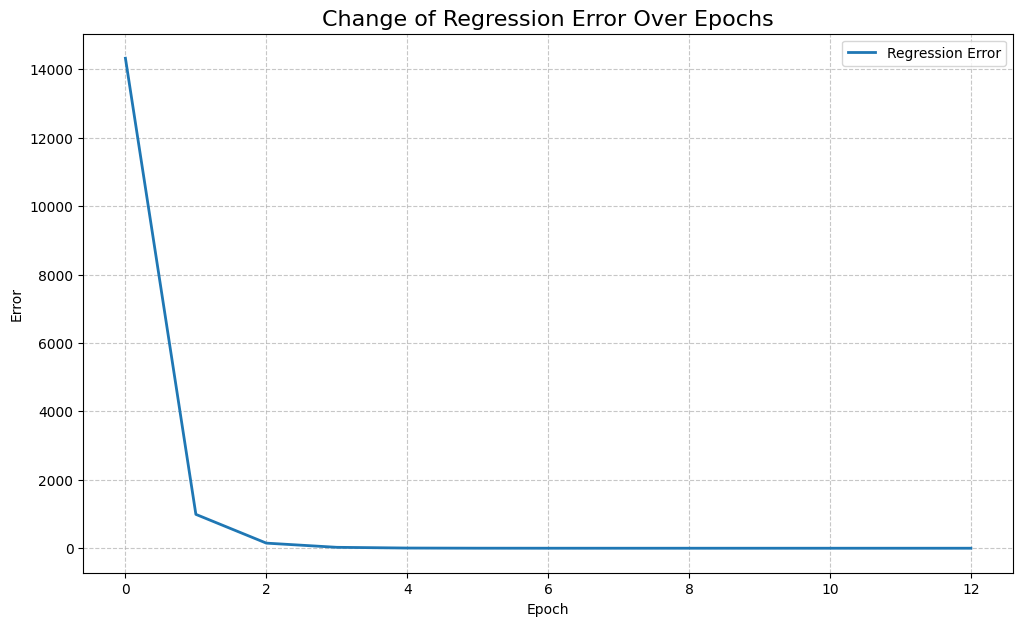

In [16]:
plt.figure(figsize=(12, 7))
plt.plot(range(len(err_hist)), err_hist, label="Regression Error", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Change of Regression Error Over Epochs", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.show()

#### WNIOSKI: Na wykresie widoczny jest gwałtowny spadek wartości wyliczanego błędu. Widoczne jest, że błąd regresji maleje w sposób płynny wraz z kolejnymi epokami. Błąd zbiega praktycznie do zera - widać również, że wystarczające jest niewiele epok, aby błąd był poniżej wartości oczekiwanej. Wszystko to wskazuje, że dane wykazują silną liniową zależność między zmiennymi. 

### Zadanie 6

W jaki sposób współczynnik alpha wpływa na działania algorytmu? Przeprowadź eksperyment dla minimum trzech różnych wartości tego parametru. Sformułuj wnioski. Jak zmiana parametru wpłynęła na ilość epok w algorytmie? Jak zmieniła się funkcja regresji?

In [17]:
alphas = [0.1, 0.05, 0.01, 1e-3, 1e-6, 1e-9]
errors_all = {}

for a in alphas:
    print(f"\n=== Test dla α = {a} ===")
    b0_hist, betas_hist, err_hist = learn_and_fit(X, y, epoch=100, stop_value=0.01, alpha=a)
    errors_all[a] = err_hist


=== Test dla α = 0.1 ===

=== Test dla α = 0.05 ===

=== Test dla α = 0.01 ===
 Warunek spełniony: err < 0.01, osiągnięto w 12 epoce

=== Test dla α = 0.001 ===
 Warunek spełniony: err < 0.01, osiągnięto w 81 epoce

=== Test dla α = 1e-06 ===

=== Test dla α = 1e-09 ===


In [18]:
for a, err in errors_all.items():
    print(f"α = {a:>7} | liczba epok = {len(err):3} | początkowy błąd = {err[0]:.2e} | końcowy błąd = {err[-1]:.2e}")


α =     0.1 | liczba epok = 100 | początkowy błąd = 1.44e+04 | końcowy błąd = 3.47e+232
α =    0.05 | liczba epok = 100 | początkowy błąd = 1.43e+04 | końcowy błąd = 4.91e+166
α =    0.01 | liczba epok =  12 | początkowy błąd = 1.45e+04 | końcowy błąd = 6.05e-03
α =   0.001 | liczba epok =  81 | początkowy błąd = 1.43e+04 | końcowy błąd = 9.58e-03
α =   1e-06 | liczba epok = 100 | początkowy błąd = 1.44e+04 | końcowy błąd = 1.40e+04
α =   1e-09 | liczba epok = 100 | początkowy błąd = 1.44e+04 | końcowy błąd = 1.44e+04


Wartość współczynnika **alpha** wpływa na to, jak szybko model się uczy. Dla przetestowanych wartości najlepszą okazała się alpha=0.01. Dla zbyt niskich jak i dla zbyt wysokich wartości alpha błąd nie został osiągnięty. Współczynnik ten musi być więc dobrze wymierzony. Zbyt duża wartość alpha może więc powodować rozbieżność rozwiązania.

### Zadanie 7

Porównaj czas działania algorytmu we własnej implementacji oraz implementacji z biblioteki Sklearn.

In [19]:
import time
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [20]:
start_custom = time.time()
b0_hist, betas_hist, err_hist = learn_and_fit(X, y, epoch=500, stop_value=0.0000001, alpha=0.01)
end_custom = time.time()
custom_time = end_custom - start_custom

 Warunek spełniony: err < 0.01, osiągnięto w 21 epoce


In [21]:
start_sklearn = time.time()
model = LinearRegression()
model.fit(X, y)
end_sklearn = time.time()
sklearn_time = end_sklearn - start_sklearn

In [22]:
print(f"Czas działania własnej implementacji: {custom_time:.5f} s")
print(f"Czas działania sklearn:               {sklearn_time:.5f} s")
print(f"Liczba epok w Twoim algorytmie:       {len(err_hist)}")

Czas działania własnej implementacji: 0.01200 s
Czas działania sklearn:               0.01400 s
Liczba epok w Twoim algorytmie:       21


In [23]:
start_custom = time.time()
b0_hist, betas_hist, err_hist = learn_and_fit(X, y, epoch=500, stop_value=0.001, alpha=0.01)
end_custom = time.time()
custom_time = end_custom - start_custom

start_sklearn = time.time()
model = LinearRegression()
model.fit(X, y)
end_sklearn = time.time()
sklearn_time = end_sklearn - start_sklearn

 Warunek spełniony: err < 0.01, osiągnięto w 14 epoce


In [24]:
print(f"Czas działania własnej implementacji: {custom_time:.5f} s")
print(f"Czas działania sklearn:               {sklearn_time:.5f} s")
print(f"Liczba epok w Twoim algorytmie:       {len(err_hist)}")

Czas działania własnej implementacji: 0.00300 s
Czas działania sklearn:               0.00200 s
Liczba epok w Twoim algorytmie:       14


In [25]:
n_runs = 5
custom_times = []
sklearn_times = []

for _ in range(n_runs):
    # Twój algorytm
    start = time.time()
    b0_hist, betas_hist, err_hist = learn_and_fit(X, y, epoch=500, stop_value=1e-3, alpha=0.01)
    end = time.time()
    custom_times.append(end - start)

    # Sklearn
    start = time.time()
    model = LinearRegression()
    model.fit(X, y)
    end = time.time()
    sklearn_times.append(end - start)

print("=== ŚREDNI CZAS DZIAŁANIA (5 URUCHOMIEŃ) ===")
print(f"Własna implementacja: {np.mean(custom_times):.6f} s ± {np.std(custom_times):.6f}")
print(f"Sklearn LinearRegression: {np.mean(sklearn_times):.6f} s ± {np.std(sklearn_times):.6f}")

 Warunek spełniony: err < 0.01, osiągnięto w 14 epoce
 Warunek spełniony: err < 0.01, osiągnięto w 14 epoce
 Warunek spełniony: err < 0.01, osiągnięto w 14 epoce
 Warunek spełniony: err < 0.01, osiągnięto w 14 epoce
 Warunek spełniony: err < 0.01, osiągnięto w 14 epoce
=== ŚREDNI CZAS DZIAŁANIA (5 URUCHOMIEŃ) ===
Własna implementacja: 0.002600 s ± 0.000489
Sklearn LinearRegression: 0.001999 s ± 0.001095


W większości przypadków biblioteka Scikit Learn uzyskuje lepsze wyniki czasowe. Widać natomiast, że wartość ta zależy także od wartości stopu zadeklarowanej w implementacji własnej algorytmu. W trakcie testów pojawiły się też sytuacje, gdzie wartość stopu została osiągnięta tak szybko, że algorytm był szybszy od wersji z biblioteki. Należy też zauważyć, że dane w tym zbiorze są silnie liniowo skorelowane, co sprzyja szybkiemu zbieżaniu się algorytmu.
Test byłby bardziej wiarygodny, gdyby przeprowadzono go na mniej liniowym, bardziej złożonym zbiorze danych.